###Google Colab setup

In [ ]:
!pip install nba_api
!pip install pyspark
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


###Import libraries

In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from itertools import chain

In [ ]:
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.endpoints import teamdashboardbylastngames
from nba_api.stats.endpoints import leaguedashteamstats
from nba_api.stats.endpoints import boxscoreadvancedv2
from nba_api.stats.static import teams

#Dataset Building
If you want to skip dataset building, go directly to Data Loading section below

Get a dataframe that contains team ids, abbervations, and nicknames for later use.

In [ ]:
team_df = pd.DataFrame(teams.get_teams())
team_df = team_df[['id', 'abbreviation', 'nickname']]

Pull all games so we can store the game ids & build rows of matchups. To save effort, load 'all_games.csv' here

In [ ]:
# all_games = leaguegamefinder.LeagueGameFinder(season_nullable='2020-21', league_id_nullable='00', season_type_nullable='Regular Season').get_data_frames()[0]
# all_game_ids = set(all_games['GAME_ID'])

In [ ]:
file_path_all_games = './gdrive/MyDrive/INFO607/NBA Notebooks/all_games.csv'
all_games = pd.read_csv(file_path_all_games)
all_game_ids = set(all_games['GAME_ID'])
all_games.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22020,1610612744,GSW,Golden State Warriors,22001070,2021-05-16,GSW vs. MEM,W,240,113,41,83,0.494,15,39,0.385,16,18,0.889,12,34,46,26,9,4,19,19,12.0
1,22020,1610612762,UTA,Utah Jazz,22001077,2021-05-16,UTA @ SAC,W,239,121,41,86,0.477,18,39,0.462,21,25,0.840,9,41,50,28,9,3,16,14,22.0
2,22020,1610612764,WAS,Washington Wizards,22001080,2021-05-16,WAS vs. CHA,W,241,115,44,91,0.484,10,31,0.323,17,21,0.810,10,43,53,22,4,3,14,20,5.0
3,22020,1610612756,PHX,Phoenix Suns,22001078,2021-05-16,PHX @ SAS,W,240,123,53,104,0.510,13,35,0.371,4,4,1.000,10,38,48,36,7,5,8,13,2.0
4,22020,1610612750,MIN,Minnesota Timberwolves,22001071,2021-05-16,MIN vs. DAL,W,241,136,49,90,0.544,17,40,0.425,21,25,0.840,11,27,38,35,11,4,9,22,15.0


Use games ids to create a dataframe of advanced metrics for every game

To save effort of running below code, load '2020-21 ADV Stats.csv' here

In [ ]:
# season_advanced=[]
# for i in all_game_ids:
#   season_advanced.append(boxscoreadvancedv2.BoxScoreAdvancedV2(game_id=i).get_normalized_dict()['TeamStats'])
# szn_adv_df = pd.DataFrame(list(chain.from_iterable(season_advanced)))
# len(all_games) == len(szn_adv_df)

In [ ]:
file_path_adv_stats = './gdrive/MyDrive/INFO607/NBA Notebooks/2020-21 ADV Stats.csv'
szn_adv_df = pd.read_csv(file_path_adv_stats)
szn_adv_df.head()

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
0,22000297,1610612762,Jazz,UTA,Utah,240:00,124.4,122.4,100.1,104.1,24.3,18.3,0.553,1.40,15.6,0.353,0.774,0.567,15.554,15.3,0.552,0.610,1.0,0.199,98.66,97.5,81.25,98,0.610
1,22000297,1610612742,Mavericks,DAL,Dallas,240:00,100.1,104.1,124.4,122.4,-24.3,-18.3,0.541,1.82,15.5,0.226,0.647,0.433,10.904,11.3,0.483,0.516,1.0,0.200,98.66,97.5,81.25,97,0.390
2,22000004,1610612756,Suns,PHX,Phoenix,240:00,102.0,102.9,99.6,99.0,2.5,3.9,0.553,1.11,16.0,0.205,0.843,0.547,18.290,18.4,0.551,0.583,1.0,0.198,103.16,103.0,85.83,103,0.551
3,22000004,1610612742,Mavericks,DAL,Dallas,240:00,99.6,99.0,102.0,102.9,-2.5,-3.9,0.472,1.42,13.6,0.157,0.795,0.453,11.714,11.7,0.476,0.529,1.0,0.199,103.16,103.0,85.83,103,0.449
4,22000809,1610612761,Raptors,TOR,Toronto,240:00,94.9,99.0,100.1,104.1,-5.2,-5.1,0.576,1.12,15.2,0.229,0.679,0.471,16.812,17.5,0.487,0.539,1.0,0.198,101.50,97.5,81.25,97,0.470


Implement Spark

In [ ]:
spark = SparkSession.builder.appName('NBA_Advanced_Stats_Model').getOrCreate()
team_spark = spark.createDataFrame(team_df)
all_games_spark = spark.createDataFrame(all_games)
szn_adv_spark = spark.createDataFrame(szn_adv_df)

In [ ]:
all_games_spark.toPandas().sort_values('GAME_ID', ascending=False).head(4)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
2,22020,1610612764,WAS,Washington Wizards,22001080,2021-05-16,WAS vs. CHA,W,241,115,44,91,0.484,10,31,0.323,17,21,0.810,10,43,53,22,4,3,14,20,5.0
22,22020,1610612766,CHA,Charlotte Hornets,22001080,2021-05-16,CHA @ WAS,L,240,110,37,94,0.394,14,45,0.311,22,24,0.917,10,32,42,25,8,5,11,15,-5.0
9,22020,1610612761,TOR,Toronto Raptors,22001079,2021-05-16,TOR vs. IND,L,240,113,39,97,0.402,12,38,0.316,23,29,0.793,16,32,48,21,8,3,12,12,-12.0
25,22020,1610612754,IND,Indiana Pacers,22001079,2021-05-16,IND @ TOR,W,239,125,48,95,0.505,15,37,0.405,14,18,0.778,10,37,47,34,8,3,13,19,12.0


In [ ]:
szn_adv_spark.toPandas().sort_values('GAME_ID', ascending=False).head(4)

,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
370,22001080,1610612764,Wizards,WAS,Washington,240:00,110.3,112.7,102.3,105.8,8.1,7.0,0.500,1.57,16.1,0.271,0.746,0.533,13.431,13.7,0.538,0.574,1.0,0.200,105.90,103.0,85.83,102,0.525
371,22001080,1610612766,Hornets,CHA,Charlotte,240:00,102.3,105.8,110.3,112.7,-8.1,-7.0,0.676,1.92,17.5,0.254,0.729,0.467,12.086,12.5,0.468,0.526,1.0,0.192,105.90,103.0,85.83,104,0.475
1160,22001079,1610612761,Raptors,TOR,Toronto,240:00,106.8,107.6,118.0,117.9,-11.2,-10.3,0.538,1.75,14.7,0.322,0.729,0.505,11.346,11.4,0.464,0.515,1.0,0.202,105.84,105.5,87.92,105,0.428
1161,22001079,1610612754,Pacers,IND,Indiana,240:00,118.0,117.9,106.8,107.6,11.2,10.3,0.708,2.62,22.7,0.271,0.678,0.495,12.273,12.3,0.584,0.607,1.0,0.200,105.84,105.5,87.92,106,0.572


In [ ]:
all_games_spark.printSchema()

root
 |-- SEASON_ID: long (nullable = true)
 |-- TEAM_ID: long (nullable = true)
 |-- TEAM_ABBREVIATION: string (nullable = true)
 |-- TEAM_NAME: string (nullable = true)
 |-- GAME_ID: long (nullable = true)
 |-- GAME_DATE: string (nullable = true)
 |-- MATCHUP: string (nullable = true)
 |-- WL: string (nullable = true)
 |-- MIN: long (nullable = true)
 |-- PTS: long (nullable = true)
 |-- FGM: long (nullable = true)
 |-- FGA: long (nullable = true)
 |-- FG_PCT: double (nullable = true)
 |-- FG3M: long (nullable = true)
 |-- FG3A: long (nullable = true)
 |-- FG3_PCT: double (nullable = true)
 |-- FTM: long (nullable = true)
 |-- FTA: long (nullable = true)
 |-- FT_PCT: double (nullable = true)
 |-- OREB: long (nullable = true)
 |-- DREB: long (nullable = true)
 |-- REB: long (nullable = true)
 |-- AST: long (nullable = true)
 |-- STL: long (nullable = true)
 |-- BLK: long (nullable = true)
 |-- TOV: long (nullable = true)
 |-- PF: long (nullable = true)
 |-- PLUS_MINUS: double (nullabl

Combine DFs to get mathcup data for splitting and rejoinin home and away

In [ ]:
all_games_spark.createOrReplaceTempView('all_games_V')
szn_adv_spark.createOrReplaceTempView('szn_adv_V')
df = spark.sql('SELECT a.MATCHUP, a.WL, a.PF, s.* FROM all_games_V a RIGHT JOIN szn_adv_V s \
                        ON a.GAME_ID = s.GAME_ID AND a.TEAM_ID = s.TEAM_ID')
df.printSchema()

root
 |-- MATCHUP: string (nullable = true)
 |-- WL: string (nullable = true)
 |-- PF: long (nullable = true)
 |-- GAME_ID: long (nullable = true)
 |-- TEAM_ID: long (nullable = true)
 |-- TEAM_NAME: string (nullable = true)
 |-- TEAM_ABBREVIATION: string (nullable = true)
 |-- TEAM_CITY: string (nullable = true)
 |-- MIN: string (nullable = true)
 |-- E_OFF_RATING: double (nullable = true)
 |-- OFF_RATING: double (nullable = true)
 |-- E_DEF_RATING: double (nullable = true)
 |-- DEF_RATING: double (nullable = true)
 |-- E_NET_RATING: double (nullable = true)
 |-- NET_RATING: double (nullable = true)
 |-- AST_PCT: double (nullable = true)
 |-- AST_TOV: double (nullable = true)
 |-- AST_RATIO: double (nullable = true)
 |-- OREB_PCT: double (nullable = true)
 |-- DREB_PCT: double (nullable = true)
 |-- REB_PCT: double (nullable = true)
 |-- E_TM_TOV_PCT: double (nullable = true)
 |-- TM_TOV_PCT: double (nullable = true)
 |-- EFG_PCT: double (nullable = true)
 |-- TS_PCT: double (nullable

In [ ]:
df.toPandas().head(5)

,MATCHUP,WL,PF,GAME_ID,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CITY,MIN,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
0,MIA vs. MIL,L,18,22000051,1610612748,Heat,MIA,Miami,240:00,91.6,94.2,136.4,139.8,-44.8,-45.6,0.622,1.05,17.4,0.178,0.667,0.414,20.770,21.4,0.538,0.558,1.0,0.198,105.76,103.0,85.83,103,0.327
1,HOU vs. SAC,W,22,22000079,1610612745,Rockets,HOU,Houston,240:00,102.9,104.1,93.8,96.9,9.1,7.2,0.417,1.07,12.5,0.217,0.717,0.500,14.124,14.3,0.525,0.560,1.0,0.198,99.68,97.5,81.25,98,0.621
2,NOP vs. MIN,L,18,22000574,1610612740,Pelicans,NOP,New Orleans,240:00,95.8,101.9,126.1,132.4,-30.3,-30.4,0.651,1.56,17.9,0.452,0.739,0.574,16.429,17.5,0.460,0.475,1.0,0.199,108.30,102.5,85.42,103,0.373
3,DAL @ DET,W,20,22000943,1610612742,Mavericks,DAL,Dallas,240:00,111.5,115.0,104.0,106.1,7.5,8.9,0.550,1.83,16.5,0.245,0.842,0.506,11.637,12.0,0.522,0.580,1.0,0.196,102.04,99.5,82.92,100,0.505
4,DET vs. DEN,L,13,22001054,1610612765,Pistons,DET,Detroit,240:00,96.7,97.8,109.3,110.6,-12.6,-12.8,0.618,2.10,16.9,0.208,0.711,0.439,10.625,10.8,0.446,0.489,1.0,0.198,94.64,93.5,77.92,93,0.425


Split Home and Away

In [ ]:
home_df = df.filter(df.MATCHUP.contains('.'))
away_df = df.filter(df.MATCHUP.contains('@'))

Create HomeWin column comprised of binary response: 1 for home team win, 0 for home team loss.

In [ ]:
home_df = home_df.withColumn('HomeWin', f.when(f.col('WL') == 'W', 1).otherwise(0))
home_df.toPandas()[['WL', 'HomeWin']].head(3)

,WL,HomeWin
0,L,0
1,W,1
2,L,0


Prepare columns for `home_` and `away_` prefixes.

In [ ]:
away_drop = ['MATCHUP', 'WL', 'GAME_ID', 'TEAM_CITY', 'MIN', 'USG_PCT']
home_drop = away_drop + ['HomeWin']
away_prep = away_df.drop(*away_drop)
home_prep = home_df.drop(*home_drop)
away_col_names = [f"away_{i}" for i in away_prep.columns]
home_col_names = [f"home_{i}" for i in home_prep.columns]
away_prep_df = away_prep.toDF(*away_col_names)
home_prep_df = home_prep.toDF(*home_col_names)

Cannot concatenate horizonatlly in PySpark. So, we'll convert some DFs to pandas, concatenate, and convert back to Spark DF

In [ ]:
final_away = spark.createDataFrame(pd.concat([away_df.toPandas()['GAME_ID'], away_prep_df.toPandas()], axis=1))
final_home = spark.createDataFrame(pd.concat([home_df.toPandas()[['GAME_ID', 'HomeWin']], home_prep_df.toPandas()], axis=1))
# This join method avoids duplicating the 'GAME_ID' column.
final_df = final_home.join(final_away, 'GAME_ID')

###Data Loading
If you want to skip dataset building above, simply load saved dataset: '2020-21 ADV Clean.csv' and Change file path accordingly. Otherwise skip this Data Loading section

Get a dataframe that contains team ids, abbervations, and nicknames for later use.

In [ ]:
team_df = pd.DataFrame(teams.get_teams())
team_df = team_df[['id', 'abbreviation', 'nickname']]

In [ ]:
spark = SparkSession.builder.appName('NBA_Advanced_Stats_Model').getOrCreate()

file_path_adv_clean = './gdrive/MyDrive/INFO607/NBA Notebooks/2020-21 ADV Clean.csv'
final_df = pd.read_csv(file_path_adv_clean)
final_df = spark.createDataFrame(final_df)
final_df.printSchema()

root
 |-- GAME_ID: long (nullable = true)
 |-- HomeWin: long (nullable = true)
 |-- home_PF: long (nullable = true)
 |-- home_TEAM_ID: long (nullable = true)
 |-- home_TEAM_NAME: string (nullable = true)
 |-- home_TEAM_ABBREVIATION: string (nullable = true)
 |-- home_E_OFF_RATING: double (nullable = true)
 |-- home_OFF_RATING: double (nullable = true)
 |-- home_E_DEF_RATING: double (nullable = true)
 |-- home_DEF_RATING: double (nullable = true)
 |-- home_E_NET_RATING: double (nullable = true)
 |-- home_NET_RATING: double (nullable = true)
 |-- home_AST_PCT: double (nullable = true)
 |-- home_AST_TOV: double (nullable = true)
 |-- home_AST_RATIO: double (nullable = true)
 |-- home_OREB_PCT: double (nullable = true)
 |-- home_DREB_PCT: double (nullable = true)
 |-- home_REB_PCT: double (nullable = true)
 |-- home_E_TM_TOV_PCT: double (nullable = true)
 |-- home_TM_TOV_PCT: double (nullable = true)
 |-- home_EFG_PCT: double (nullable = true)
 |-- home_TS_PCT: double (nullable = true)
 |-

#Data Preprocessing

Remove unnecessary columns and columns that provide too much certainty.

In [ ]:
no_e_cols = ['GAME_ID', 'home_TEAM_ID', 'home_TEAM_NAME', 'home_TEAM_ABBREVIATION', 'away_TEAM_ID', 'away_TEAM_NAME', 'away_TEAM_ABBREVIATION',
             'home_E_OFF_RATING', 'home_E_DEF_RATING', 'home_E_NET_RATING', 'home_E_TOV_PCT', 'home_E_USG_PCT', 
             'home_E_PACE', 'home_E_TM_TOV_PCT', 'away_E_OFF_RATING', 'away_E_DEF_RATING', 'away_E_NET_RATING', 'away_E_TOV_PCT', 
             'away_E_USG_PCT', 'away_E_PACE', 'away_E_TM_TOV_PCT']
no_e_cols = [i for i in final_df.columns if i not in no_e_cols]
no_e_df = final_df[no_e_cols]

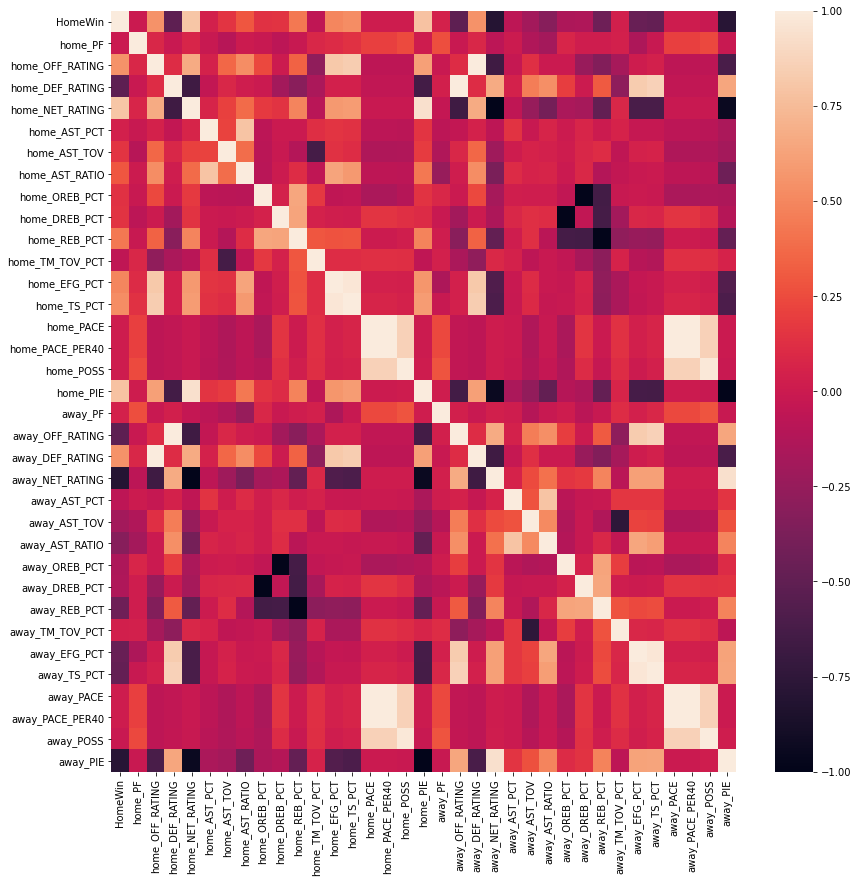

In [ ]:
plt.figure(figsize = (14,14))
sns.heatmap(no_e_df.toPandas().corr())
plt.show()

In [ ]:
corr_df = no_e_df.toPandas().corr()
j=0
for i in corr_df.columns:
    print(f"Correlation of {i} = {corr_df.iloc[0][j]}")
    j+=1

Correlation of HomeWin = 1.0
Correlation of home_PF = -0.005124661396481382
Correlation of home_OFF_RATING = 0.5514710268334349
Correlation of home_DEF_RATING = -0.5103507703985566
Correlation of home_NET_RATING = 0.7976867114406786
Correlation of home_AST_PCT = 0.04281312802933664
Correlation of home_AST_TOV = 0.15449016805162763
Correlation of home_AST_RATIO = 0.28915650145814936
Correlation of home_OREB_PCT = 0.13993821972819223
Correlation of home_DREB_PCT = 0.1446554760544476
Correlation of home_REB_PCT = 0.4313031023632588
Correlation of home_TM_TOV_PCT = -0.05939278543760837
Correlation of home_EFG_PCT = 0.49256659456739893
Correlation of home_TS_PCT = 0.5272480744358221
Correlation of home_PACE = 0.014665816264461805
Correlation of home_PACE_PER40 = 0.014652131647588709
Correlation of home_POSS = 0.00853139564073335
Correlation of home_PIE = 0.787159416333853
Correlation of away_PF = 0.05417077316825929
Correlation of away_OFF_RATING = -0.5103507703985566
Correlation of away_DE

Drop columns that have extremely low correlations.

In [ ]:
# low_corr=[]
# for i in range(len(corr_df.columns)):
#     if abs(corr_df.iloc[0][i]) < .1:
#         low_corr.append(corr_df.columns[i])
# no_e_df = no_e_df.drop(*low_corr)
# df = no_e_df
# df.show(5)

### Prepare data with VectorAssembler

In [ ]:
from pyspark.ml.feature import VectorAssembler

inputCols = no_e_df.toPandas().drop(['home_PF','away_PF','HomeWin'], axis = 1).columns.tolist()
va = VectorAssembler(inputCols = inputCols, outputCol = 'features')
va_df = va.transform(no_e_df)
va_df = va_df.select(['features', 'HomeWin'])
va_df.show(5)

+--------------------+-------+
|            features|HomeWin|
+--------------------+-------+
|[114.3,99.0,15.3,...|      1|
|[101.0,110.9,-9.9...|      0|
|[108.1,111.1,-3.0...|      0|
|[94.7,89.5,5.2,0....|      1|
|[133.7,107.8,25.9...|      1|
+--------------------+-------+
only showing top 5 rows



### Standardize Data

In [ ]:
from pyspark.ml.feature import StandardScaler

standardscaler = StandardScaler().setInputCol("features").setOutputCol("scaled_features")
scaled_df = standardscaler.fit(va_df).transform(va_df)
scaled_df.select("features","scaled_features").show(5)

+--------------------+--------------------+
|            features|     scaled_features|
+--------------------+--------------------+
|[114.3,99.0,15.3,...|[10.0712465091536...|
|[101.0,110.9,-9.9...|[8.89935168350407...|
|[108.1,111.1,-3.0...|[9.52494967313654...|
|[94.7,89.5,5.2,0....|[8.34424360819639...|
|[133.7,107.8,25.9...|[11.7806269315296...|
+--------------------+--------------------+
only showing top 5 rows



###Train, test dataset split

In [ ]:
train_test_split = scaled_df.randomSplit([0.8, 0.2], seed=76)
train = train_test_split[0]
test = train_test_split[1]

###Class imbalance handling

In [ ]:
from pyspark.sql.functions import when

dataset_size = float(train.select("HomeWin").count())
numPositives = train.select("HomeWin").where('HomeWin == 1').count()
win_per = (float(numPositives)/float(dataset_size))*100
numNegatives = float(dataset_size - numPositives)
print(f'Percentage of wins in datasets is {win_per:.2f}% and loses is {100 - win_per:.2f}%')

BalancingRatio = numNegatives/dataset_size
print('BalancingRatio = {}'.format(BalancingRatio))

train = train.withColumn("classWeights", \
      when(train.HomeWin == 1, BalancingRatio).otherwise(1 - BalancingRatio))
train.select("classWeights").show(5)

Percentage of wins in datasets is 54.90% and loses is 45.10%
BalancingRatio = 0.45098039215686275
+------------------+
|      classWeights|
+------------------+
|0.5490196078431373|
|0.5490196078431373|
|0.5490196078431373|
|0.5490196078431373|
|0.5490196078431373|
+------------------+
only showing top 5 rows



###Feature selection

In [ ]:
from pyspark.ml.feature import ChiSqSelector

css = ChiSqSelector(featuresCol='scaled_features',outputCol='optimal_features',labelCol='HomeWin',fpr=0.05)
train = css.fit(train).transform(train)
test = css.fit(test).transform(test)
test.select("optimal_features").show(5)

+--------------------+
|    optimal_features|
+--------------------+
|[7.98298279728187...|
|[8.08871766876905...|
|[8.15920758309383...|
|[8.22088625812802...|
|[8.26494245458101...|
+--------------------+
only showing top 5 rows



# Model Building and Evaluating

### Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol='optimal_features', labelCol='HomeWin', maxIter=10, regParam=0.3, elasticNetParam=0.8, weightCol="classWeights")
lr_model = lr.fit(train)
lr_predictions_test = lr_model.transform(test)
lr_predictions_test.select("HomeWin","prediction",'rawPrediction', 'probability').show(10)

+-------+----------+--------------------+--------------------+
|HomeWin|prediction|       rawPrediction|         probability|
+-------+----------+--------------------+--------------------+
|      1|       1.0|[-0.6711867952855...|[0.33823114843478...|
|      0|       0.0|[0.56224951404610...|[0.63697287448877...|
|      0|       0.0|[0.20043359449109...|[0.54994131681424...|
|      0|       0.0|[0.58668917985072...|[0.64260512976218...|
|      0|       0.0|[0.81222623088626...|[0.69258369761014...|
|      0|       0.0|[0.82379173809579...|[0.69504062754701...|
|      0|       0.0|[0.87257249153625...|[0.70528069789377...|
|      0|       0.0|[0.94887682852690...|[0.72088924307933...|
|      1|       1.0|[-0.8736421209864...|[0.29449701793419...|
|      0|       0.0|[0.70696068294514...|[0.66972923436772...|
+-------+----------+--------------------+--------------------+
only showing top 10 rows



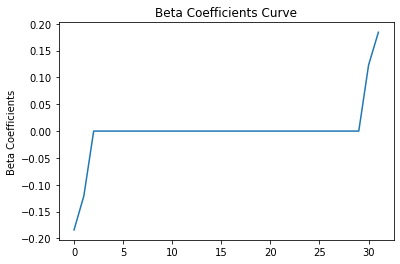

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lr_model.coefficients)
plt.plot(beta)
plt.ylabel("Beta Coefficients")
plt.title("Beta Coefficients Curve")
plt.show()

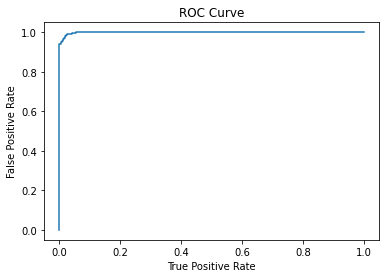

Logistic Regression Model - Train set area under ROC is: 0.9988609254443459


In [ ]:
summary = lr_model.summary
roc = summary.roc.toPandas()
plt.plot(roc["FPR"], roc["TPR"])
plt.ylabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()
print(f"Logistic Regression Model - Train set area under ROC is: {summary.areaUnderROC}")

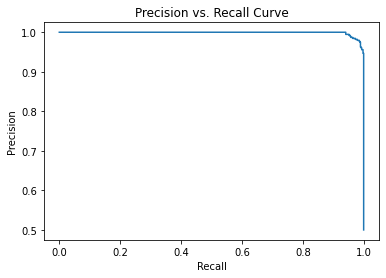

In [ ]:
pr = summary.pr.toPandas()
plt.plot(pr['recall'], pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision vs. Recall Curve')
plt.show()

Logistic Regression Model Evaluation

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr_evaluator = BinaryClassificationEvaluator(labelCol='HomeWin')
print("Logistic Regression Model - Test set area under ROC is {:.3}".format(lr_evaluator.evaluate(lr_predictions_test)))

Logistic Regression Model - Test set area under ROC is 0.999


### Decision Tree
First transform optimal_features from sparseVector to denseVector

In [ ]:
from pyspark.ml.linalg import DenseVector, Vectors, VectorUDT

toDense = lambda v: Vectors.dense(v.toArray())
toDenseUdf = f.udf(toDense, VectorUDT())
train = train.withColumn('optimal_features', toDenseUdf('optimal_features'))
test = test.withColumn('optimal_features', toDenseUdf('optimal_features'))           
test.show(10)

+--------------------+-------+--------------------+--------------------+
|            features|HomeWin|     scaled_features|    optimal_features|
+--------------------+-------+--------------------+--------------------+
|[90.6,82.1,8.5,0....|      1|[7.98298279728187...|[7.98298279728187...|
|[91.8,104.1,-12.3...|      0|[8.08871766876905...|[8.08871766876905...|
|[92.6,97.9,-5.3,0...|      0|[8.15920758309383...|[8.15920758309383...|
|[93.3,110.7,-17.4...|      0|[8.22088625812802...|[8.22088625812802...|
|[93.8,114.3,-20.5...|      0|[8.26494245458101...|[8.26494245458101...|
|[93.8,116.1,-22.3...|      0|[8.26494245458101...|[8.26494245458101...|
|[95.1,119.4,-24.3...|      0|[8.37948856535878...|[8.37948856535878...|
|[96.9,122.4,-25.5...|      0|[8.53809087258955...|[8.53809087258955...|
|[97.2,85.0,12.1,0...|      1|[8.56452459046135...|[8.56452459046135...|
|[97.2,117.0,-19.8...|      0|[8.56452459046135...|[8.56452459046135...|
+--------------------+-------+--------------------+

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'optimal_features', labelCol = "HomeWin", maxDepth = 3, weightCol="classWeights")
dt_model = dt.fit(train)
dt_prediction_test = dt_model.transform(test)
dt_prediction_test.select("HomeWin", "prediction", "probability").show(10)

+-------+----------+--------------------+
|HomeWin|prediction|         probability|
+-------+----------+--------------------+
|      1|       1.0|           [0.0,1.0]|
|      0|       0.0|[0.98321780372126...|
|      0|       0.0|[0.98321780372126...|
|      0|       0.0|[0.98321780372126...|
|      0|       0.0|[0.98321780372126...|
|      0|       0.0|[0.98321780372126...|
|      0|       0.0|[0.98321780372126...|
|      0|       0.0|[0.98321780372126...|
|      1|       1.0|           [0.0,1.0]|
|      0|       0.0|[0.98321780372126...|
+-------+----------+--------------------+
only showing top 10 rows



Decision Tree Model Evaluation

In [ ]:
dt_evaluator = BinaryClassificationEvaluator(labelCol='HomeWin')
print("Decision Tree Model - Test area under ROC is: " + str(dt_evaluator.evaluate(dt_prediction_test, {dt_evaluator.metricName: "areaUnderROC"})))

Decision Tree Model - Test area under ROC is: 0.9996025437201909


###Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'optimal_features', labelCol = 'HomeWin',weightCol="classWeights")
rf_model = rf.fit(train)
rf_prediction_test = rf_model.transform(test)
rf_prediction_test.select('HomeWin', 'prediction', 'rawPrediction', 'probability').show(10)

+-------+----------+--------------------+--------------------+
|HomeWin|prediction|       rawPrediction|         probability|
+-------+----------+--------------------+--------------------+
|      1|       1.0|[0.03187968304671...|[0.00159398415233...|
|      0|       0.0|[19.9589421395899...|[0.99794710697949...|
|      0|       0.0|[19.9243428946166...|[0.99621714473083...|
|      0|       0.0|[19.9254453043839...|[0.99627226521919...|
|      0|       0.0|[19.9425110866722...|[0.99712555433361...|
|      0|       0.0|[19.9425110866722...|[0.99712555433361...|
|      0|       0.0|[19.9637914197557...|[0.99818957098778...|
|      0|       0.0|[19.9765235677401...|[0.99882617838700...|
|      1|       1.0|[1.02642584588270...|[0.05132129229413...|
|      0|       0.0|[19.9425110866722...|[0.99712555433361...|
+-------+----------+--------------------+--------------------+
only showing top 10 rows



Random Forest Model Evaluation

In [ ]:
rf_evaluator = BinaryClassificationEvaluator(labelCol='HomeWin')
print("Random Forest Model - Test area under ROC is: " + str(rf_evaluator.evaluate(rf_prediction_test, {rf_evaluator.metricName: "areaUnderROC"})))

Random Forest Model - Test area under ROC is: 0.9999116763822645


###Gradient-Boosted Tree 

In [ ]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol = 'optimal_features', labelCol = 'HomeWin', maxIter=10,weightCol="classWeights")
gbt_model = gbt.fit(train)
gbt_prediction_test = gbt_model.transform(test)
gbt_prediction_test.select('HomeWin', 'prediction', 'rawPrediction', 'probability').show(10)

+-------+----------+--------------------+--------------------+
|HomeWin|prediction|       rawPrediction|         probability|
+-------+----------+--------------------+--------------------+
|      1|       1.0|[-1.3272286551576...|[0.06571481646267...|
|      0|       0.0|[1.32590267922033...|[0.93412217565278...|
|      0|       0.0|[1.32590267922033...|[0.93412217565278...|
|      0|       0.0|[1.32590267922033...|[0.93412217565278...|
|      0|       0.0|[1.32590267922033...|[0.93412217565278...|
|      0|       0.0|[1.32590267922033...|[0.93412217565278...|
|      0|       0.0|[1.32590267922033...|[0.93412217565278...|
|      0|       0.0|[1.32590267922033...|[0.93412217565278...|
|      1|       1.0|[-1.3272286551576...|[0.06571481646267...|
|      0|       0.0|[1.32590267922033...|[0.93412217565278...|
+-------+----------+--------------------+--------------------+
only showing top 10 rows



Gradient-Boosted Tree Model Evaluation

In [ ]:
gbt_evaluator = BinaryClassificationEvaluator(labelCol='HomeWin')
print("Gradient-Boosted Tree Model - Test area under ROC is: " + str(gbt_evaluator.evaluate(gbt_prediction_test, {gbt_evaluator.metricName: "areaUnderROC"})))

Gradient-Boosted Tree Model - Test area under ROC is: 0.998586822116234


Random Forest Model is selected based on best ROC outcome

###Random Forest Tuning

In [ ]:
print(rf.explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

Create ParamGrid with cross validation

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder().addGrid(rf.maxDepth, [2, 4, 6])
                               .addGrid(rf.maxBins, [20, 60])
                               .addGrid(rf.numTrees, [10, 40])
                               .build()
)
cv = CrossValidator(estimator = rf, estimatorParamMaps = paramGrid, evaluator = rf_evaluator, numFolds = 5)
cv_model = cv.fit(train)
tuned_rf_prediction = cv_model.transform(test)

print("Tuned Random Forest Model - Test area under ROC is: " + str(rf_evaluator.evaluate(tuned_rf_prediction, \
                                                                    {rf_evaluator.metricName: "areaUnderROC"})))

Tuned Random Forest Model - Test area under ROC is: 0.954056437389771


As a result, the Random Forest model gives best performance for dataset, tunning is not improving the current parameter setting.

#Test with last random 5 games advanced stats

Get a dataframe of 5 games in the mid-May with advanced stats by loading saved csv file: 'last_five.csv'

In [ ]:
# DF for competive window before playoff positioning locks
# team_adv = leaguedashteamstats.LeagueDashTeamStats(measure_type_detailed_defense='Advanced',
#                                                    date_from_nullable='05/06/2021', date_to_nullable='05/14/2021').get_data_frames()[0]
# DF of last 5
# team_adv = leaguedashteamstats.LeagueDashTeamStats(last_n_games=5, measure_type_detailed_defense='Advanced', timeout=100).get_data_frames()[0]

In [ ]:
file_path_last_five = './gdrive/MyDrive/INFO607/NBA Notebooks/last_five.csv'
last_five_df = pd.read_csv(file_path_last_five)
last_five_df.head()

,Unnamed: 0,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TO,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,OFF_RATING_RANK,DEF_RATING_RANK,NET_RATING_RANK,AST_PCT_RANK,AST_TO_RANK,AST_RATIO_RANK,OREB_PCT_RANK,DREB_PCT_RANK,REB_PCT_RANK,TM_TOV_PCT_RANK,EFG_PCT_RANK,TS_PCT_RANK,PACE_RANK,PIE_RANK,CFID,CFPARAMS
0,0,1610612737,Atlanta Hawks,5,4,1,0.8,240.0,117.8,118.4,107.1,108.9,10.7,9.5,0.539,2.12,17.5,0.262,0.760,0.523,0.112,0.557,0.595,104.3,103.10,85.92,516,0.539,1,4,4,4,5,7,7,4,25,12,18,14,8,6,6,7,6,3,5,10,Atlanta Hawks
1,1,1610612738,Boston Celtics,5,1,4,0.2,240.0,108.6,111.9,113.8,113.7,-5.2,-1.8,0.577,2.03,17.7,0.250,0.777,0.496,0.119,0.540,0.564,100.8,99.30,82.75,496,0.464,1,21,21,21,5,20,15,21,22,18,17,21,5,18,11,18,19,15,21,10,Boston Celtics
2,2,1610612751,Brooklyn Nets,5,5,0,1.0,240.0,123.3,122.1,106.4,111.1,16.8,11.1,0.699,2.64,22.7,0.183,0.680,0.477,0.119,0.629,0.654,99.3,97.60,81.33,488,0.595,1,1,1,1,5,3,13,2,1,2,1,29,29,26,10,1,1,27,1,10,Brooklyn Nets
3,3,1610612766,Charlotte Hornets,5,0,5,0.0,245.0,101.7,105.6,114.5,114.5,-12.9,-9.0,0.668,1.87,18.0,0.304,0.752,0.505,0.137,0.479,0.518,100.3,98.45,82.04,503,0.452,1,27,27,27,2,25,17,25,4,23,16,3,11,13,22,29,29,21,24,10,Charlotte Hornets
4,4,1610612741,Chicago Bulls,5,3,2,0.6,240.0,109.2,109.8,106.8,108.6,2.4,1.2,0.612,2.03,18.5,0.267,0.774,0.524,0.127,0.540,0.560,98.9,97.80,81.50,490,0.508,1,9,9,9,5,22,5,18,14,19,13,13,6,4,16,16,22,25,17,10,Chicago Bulls


Build some functoins to avoid a further mess of local variables than we already have

In [ ]:
def nickname_to_id(nickname=''):
    return team_df[team_df['nickname'] == nickname].iloc[0][0]

def gen_data(nickname=''):
    return last_five_df[last_five_df['TEAM_ID'] == nickname_to_id(nickname)]

def away_cols(nickname=''):
    new_df = gen_data(nickname)
    new_df = new_df.rename(columns={'AST_TO': 'AST_TOV'})
    new_df = new_df.add_prefix('away_')
    return new_df
    
def home_cols(nickname=''):
    new_df = gen_data(nickname)
    new_df = new_df.rename(columns={'AST_TO': 'AST_TOV'})
    new_df = new_df.add_prefix('home_')
    return new_df

def matchup(home='', away=''):
    home_team = home_cols(home)
    away_team = away_cols(away)
    home_data = [i for i in no_e_df.columns if i in home_cols(home).columns]
    away_data = [i for i in no_e_df.columns if i in away_cols(away).columns]
    final_home = home_team[home_data].reset_index(drop=True)
    final_away = away_team[away_data].reset_index(drop=True)
    final_line = pd.concat([final_home, final_away], axis=1)
    return final_line

def winner(home='', away=''):
    match_df = matchup(home,away)
    spark_match = spark.createDataFrame(match_df)
    va = VectorAssembler(inputCols = spark_match.columns, outputCol = 'features')
    va_df = va.transform(spark_match)
    game = va_df.select('features')
    return game

Scale the data for the mathcup according to our training data and build new Random Forest model to use on last_five_df.

In [ ]:
rf2 = RandomForestClassifier(featuresCol = 'scaled_features', labelCol = 'HomeWin',weightCol="classWeights")
rf_model2 = rf2.fit(train)

## Predict 5/22/21-5/23/21 slate of games (1st games of NBA playoff matchups):
### Bucks vs. Heat (109-107), Clippers vs. Mavericks (103-113), Nets vs. Celtics (104-93), Nuggets vs. Trail Blazers (109-123), 76ers vs. Wizards (125-118), Suns vs. Lakers (99-90), Knicks vs. Hawks (105-107), Jazz vs. Grizzlies (109-112)
* 1.0 indicates model predicts Home team win

In [ ]:
rf_model2.transform(standardscaler.fit(va_df).transform(winner('Bucks', 'Heat'))).select('prediction', 'probability').show(1,False)

+----------+----------------------------------------+
|prediction|probability                             |
+----------+----------------------------------------+
|0.0       |[0.5316385773296213,0.46836142267037867]|
+----------+----------------------------------------+



In [ ]:
rf_model2.transform(standardscaler.fit(va_df).transform(winner('Clippers', 'Mavericks'))).select('prediction', 'probability').show(1,False)

+----------+---------------------------------------+
|prediction|probability                            |
+----------+---------------------------------------+
|0.0       |[0.5198877531842735,0.4801122468157266]|
+----------+---------------------------------------+



In [ ]:
rf_model2.transform(standardscaler.fit(va_df).transform(winner('Nets', 'Celtics'))).select('prediction', 'probability').show(1,False)

+----------+----------------------------------------+
|prediction|probability                             |
+----------+----------------------------------------+
|1.0       |[0.14537914928397744,0.8546208507160225]|
+----------+----------------------------------------+



In [ ]:
rf_model2.transform(standardscaler.fit(va_df).transform(winner('Nuggets', 'Trail Blazers'))).select('prediction', 'probability').show(1,False)

+----------+---------------------------------------+
|prediction|probability                            |
+----------+---------------------------------------+
|0.0       |[0.7052014381029037,0.2947985618970963]|
+----------+---------------------------------------+



In [ ]:
rf_model2.transform(standardscaler.fit(va_df).transform(winner('76ers', 'Wizards'))).select('prediction', 'probability').show(1,False)

+----------+---------------------------------------+
|prediction|probability                            |
+----------+---------------------------------------+
|0.0       |[0.6915920076938218,0.3084079923061783]|
+----------+---------------------------------------+



In [ ]:
rf_model2.transform(standardscaler.fit(va_df).transform(winner('Suns', 'Lakers'))).select('prediction', 'probability').show(1,False)

+----------+----------------------------------------+
|prediction|probability                             |
+----------+----------------------------------------+
|0.0       |[0.7408855900179366,0.25911440998206337]|
+----------+----------------------------------------+



In [ ]:
rf_model2.transform(standardscaler.fit(va_df).transform(winner('Knicks', 'Hawks'))).select('prediction', 'probability').show(1,False)

+----------+-------------------------------------+
|prediction|probability                          |
+----------+-------------------------------------+
|0.0       |[0.690811643524207,0.309188356475793]|
+----------+-------------------------------------+



In [ ]:
rf_model2.transform(standardscaler.fit(va_df).transform(winner('Jazz', 'Grizzlies'))).select('prediction', 'probability').show(1,False)

+----------+---------------------------------------+
|prediction|probability                            |
+----------+---------------------------------------+
|0.0       |[0.5819706679861019,0.4180293320138982]|
+----------+---------------------------------------+



#### In an 8 game sample of playoff matchups, the model only predicted the home team to win 1 time (this particular prediction was correct). Overall, the model made 5 correct predictions and 3 incorrect predictions for 62.5% accuracy. This is impressive considering it makes the prediction using only averages of our features from a separate timeframe.